In [37]:
#from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
from numpy import linalg as LA
from math import radians, cos, sin, asin, sqrt, dist
from scipy.stats import truncnorm
from ortools.sat.python import cp_model

import numpy as np
import pandas as pd
import geopy.distance
import rvo2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go


<Figure size 3600x720 with 0 Axes>

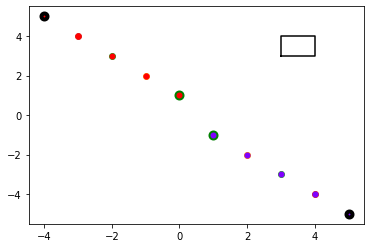

<Figure size 3600x720 with 0 Axes>

In [35]:
#---------------------------------- RVO Algorithm ----------------------------------
sim = rvo2.PyRVOSimulator(1, #float timeStep
                          1,   # float MAX neighborDist
                          5,     # size_t maxNeighbors
                          1,   # float timeHorizon --->  tiempo de respuesta frente la presencia de otros agentes
                          2,     # float timeHorizonObst ---> tiempo de respuesta frente a presencia de obstaculos
                          1,   # float radius ---> of agents
                          2)     # float maxSpeed ---> of agents
                                 # tuple velocity=(0, 0)

# Pass either just the position (the other parameters then use
# the default values passed to the PyRVOSimulator constructor),
# or pass all available parameters.
a0 = sim.addAgent((0, 0))
a1 = sim.addAgent((1, 0))
a2 = sim.addAgent((1, 1))

a3 = sim.addAgent((0, 1), #position
                   1,   #neighborDist
                   5,     #maxNeighbors
                   1,   #timeHorizon
                   2,     #timeHorizonObst
                   1,   #radius
                   2,     #maxSpeed
                   (0, 0))#velocity
 
 
# Obstacles are also supported.
sim.addObstacle
o1 = sim.addObstacle([(3, 3), (3, 4), (4, 3),(4,4)])
sim.processObstacles()
#print(sim.processObstacles())

sim.setAgentPrefVelocity(a0, (1, -1))
sim.setAgentPrefVelocity(a1, (-1, 1))
sim.setAgentPrefVelocity(a2, (-1, -1))
sim.setAgentPrefVelocity(a3, (1, -1))

#print('Simulation has %i agents and %i obstacle vertices in it.' %
      #(sim.getNumAgents(), sim.getNumObstacleVertices()))

#print('Running simulation')


for step in range(5):
    sim.doStep()

    positions = ['(%5.3f, %5.3f)' % sim.getAgentPosition(agent_no)
                 for agent_no in (a0, a1)]
    #print('step=%2i  t=%.3f  %s' % (step, sim.getGlobalTime(), '  '.join(positions)))
    
    xi=[]
    yi=[]
    for i in range(len(positions)):
      temp=positions[i]
      temp= temp.replace('(','')
      temp=temp.replace(')','')
      temp=temp.split(',')
      xi.append(float(temp[0]))
      yi.append(float(temp[1]))
    
    colors = cm.rainbow(np.linspace(0, 1, len(yi)))
    plt.scatter(x=xi,y=yi)
    
    for i in range(len(yi)):
      if step==0:
        plt.scatter(xi[i], yi[i], color=colors[i],edgecolor='green', linewidth=4) 
      if step==4:
        plt.scatter(xi[i], yi[i], color=colors[i],edgecolor='black', linewidth=4) 
      else:
        plt.scatter(xi[i], yi[i], color=colors[i],edgecolor='black', linewidth=0) 

plt.plot([3,3,4,4,3],[3,4,4,3,3],color='black')
plt.figure(figsize=(50, 10))




In [ ]:
#---------------------------------- EXTRACT THE DATA ----------------------------------

# users-melbcbd-generated.csv contains:
# •  Latitude-Longitude
# of the users in the Melbourne CBD area.
users_path = 'eua-dataset\\users\\'
U = pd.read_csv(users_path + 'users-test.csv')

# site-optus-melbCBD.csv contains:
# •  SiteID-Latitude-Longitude-Name-State-LicensingAreaID-PostCode-SitePrecision-Elevation-HCISL2
# of all Optus BS in Melbourne CBD area (edge-servers)
servers_path = 'eua-dataset\\edge-servers\\'
S = pd.read_csv(servers_path + 'serverstest.csv')

In [ ]:
#---------------------------------- VARIABLES ----------------------------------

U_si = [] # Set of individuals allocated to server si

D = (-37.81952,144.95714099999998)  # Danger source position
D_rad = 0.5  # Influence range of danger source D (radius) in km

U_per = np.full(len(U),0.2)  # Perception range of individual uj in km
R = np.zeros((4), dtype=int) # R = [CPU, RAM, VRAM, bandwidth]

# User u has memory requirements = w (example for 8 users)
w1 = [0.5, 0.5, 0.5, 2] 
w2 = [0.5, 1, 0.5, 2]
w3 = [1, 1, 0.5, 2]
w4 = [1, 1.5, 0.5, 2]
w5 = [1.5, 1.5, 1, 2]
w6 = [1, 1.5, 0.5, 2]
w7 = [0.5, 1, 0.5, 2]
w8 = [0.5, 0.5, 0.5, 2]
W = [w1, w2, w3, w4, w5, w6, w7, w8]   
  
# Each server has memory capacity c (example for 3 servers)
c1 = [2, 3, 1.5, 5]
c2 = [3, 4, 2.5, 4]
c3 = [5, 6, 2.5, 10]
C = [c1, c2, c3]    

T_1 =0 # Starting point of period
T_2 = 61 # Ending point of period
T = T_2-T_1 # Total interval time
ti = np.random.randint(T_1,T_2) # Random time step in the given period

lambd = 0.5 # Severity of the stimulus event
nej = np.random.uniform(0,1,len(U)) # Emotional fluctuation of uj ---> nej ∈ (0, 1)
se_j =np.random.uniform(0.05,0.1, len(U)) # Individual sensitivity uj 
    
du_Dt=[]  # Distance between danger and user (change with t ?????????????????????)


In [ ]:
#---------------------------------- COVERAGE OF EACH SERVER ----------------------------------

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

for i in range(len(S)):
  server_latitude = S.iloc[i]['LATITUDE']
  server_longitude = S.iloc[i]['LONGITUDE']
  temp = []

  for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']

    radius = 0.03 # In kilometer

    dist_geo = haversine(server_longitude, server_latitude, user_longitude, user_latitude)
    #dist_temp.append(dist_geo)

    if dist_geo <= radius:
        temp.append(1)
        
    else:
        temp.append(0)

  U_si.append(temp)


In [ ]:
###Get user coordinates at time t ---------- RVO algorithm
""" def realTimeLocation():
    ti = np.random.randint(T_1,T_2)
    for j in range(len(U)):
        user_latitude = U.iloc[j]['Latitude']
        user_longitude = U.iloc[j]['Longitude']
    return ti,user_latitude,user_longitude """
    
for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']
    user_coordinates = (user_latitude,user_longitude)
    dist_geoDanger = geopy.distance.geodesic(user_coordinates, D).km
    du_Dt.append(dist_geoDanger)

   

In [ ]:
#---------------------------------- CRITICALITY MODEL ----------------------------------

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def criticality (time):
    # emj: emotional value
    em_t = np.zeros(len(U))
    for j in range(len(U)):
        if du_Dt[j] < (D_rad+U_per[j]):
            eq = ((time-T_1)/T) * (1-(du_Dt[j]/(D_rad+U_per[j])))*lambd* nej[j]
            em_t[j]=eq
        else:
            em_t[j]=0

    # scrj(t) = sej + emj (t) (subjective criticality equation)
    scr=np.zeros(len(U))
    for j in range(len(U)):
        scr[j]= (se_j[j]+em_t[j])

    ocr_j=np.zeros(len(U)) # ocr objective criticality of individual uj at time step t
    nDiv = 5 # Number of partitions of the coverage area
    circles = D_rad/nDiv # Radius of each circular partition
    covCircles = [] # Distance from the center
    ri = [0.5,0.4,0.3,0.2,0.1]

    for p in range(1,nDiv+1):
        covCircles.append(circles*p)

    for j in range(len(U)):
            if du_Dt[j]<covCircles[0]:
                ocr_j[j] = ri[0]

            elif du_Dt[j]<covCircles[1] and du_Dt[j]>=covCircles[0]:
                ocr_j[j]  =ri[1]

            elif du_Dt[j]<covCircles[2] and du_Dt[j]>=covCircles[1]:
                ocr_j[j]  = ri[2]

            elif du_Dt[j]<covCircles[3] and du_Dt[j]>=covCircles[2]:
                ocr_j[j] = ri[3]
            elif du_Dt[j]<covCircles[4] and du_Dt[j]>=covCircles[3]:
                ocr_j[j]  = ri[4]

            else:
                ocr_j[j]  = 0


    # Criticality equation
    # CRj = (L1 * scrj(t)) + (L2 * ocrj)
    mu=1
    sigma=0.05
    low=0.95
    up =1.05

    X = get_truncated_normal(mu, sigma, low, up)

    #L1 =X.rvs() # weight lambda 1
    L1 = 0.95
    L2 = 1 # weight lambda 2

    # Criticality
    CR = []

    for j in range(len(U)):
        cr = (L1*scr[j])+(L2*ocr_j[j])
        CR.append(cr)

    index_CR=sorted(range(len(CR)), key=lambda a: CR[a],reverse=True)

    return index_CR, CR

In [ ]:
index_CR_t,CR_t =criticality(ti)

In [ ]:
#---------------------------------- CP MODEL ----------------------------------
model = cp_model.CpModel()

#---------------------------------- SOLVER VARIABLES ----------------------------------
# x_i,j = True if user u_j is allocated to edge server s_i
# x_i,j = False otherwise
x = {}
for j in index_CR_t:
    for i in range(len(S)):
        x[i, j] = model.NewBoolVar(f'c[{i}][{j}]')

# y_i = True if Sum(xij) > 0, ∀i ∈ {1, . . . , m}
# y_i = False otherwise
y = {}
for i in range(len(S)):
    y[i] = model.NewBoolVar(f'c[{i}]')
""" for i in range(len(S)):
                y[i] = solver.BoolVar(f'solver.Sum([x[i, j] for j in index_CR])>0') """
               

print(model.ModelStats())

In [ ]:
#---------------------------------- CONSTRAINTS ----------------------------------

# Capacity constraint
for i in range(len(S)):
    for k in range(len(R)):
        model.Add(
            sum([
                x[i,j] * W[j][k] for j in index_CR_t
            ]) <= C[i][k]*y[i]
        )
    
# Each user can be allocated just once
for j in index_CR_t:
    model.Add(
        sum([
            x[i, j] for i in range(len(S))
        ]) <= 1
    )

#Coverage
for j in index_CR_t:
    for i in range(len(S)):
        if U_si[i][j] == 0:
            model.Add(
             x[i, j]==0
            )

#yi
""" for i in range(len(S)):
    if solver.Sum([x[i,j] for j in index_CR])==0:
        solver.Add(y[i]==0) """

print(model.ModelStats())

In [ ]:
#---------------------------------- CP SOLVER ----------------------------------
solver = cp_model.CpSolver()

#---------------------------------- OBJECTIVE FUNCTIONS ---------------------------------

# Maximize the number of allocated users
objective_max = []
for j in index_CR_t:
    for i in range(len(S)):
        objective_max.append(x[i, j])
model.Maximize(sum(objective_max))

solver.Solve(model)
max_users = solver.ObjectiveValue()

# Hint (speed up solving)
for j in index_CR_t:
    for i in range(len(S)):
        model.AddHint(x[i,j], solver.Value(x[i,j]))

for i in range(len(S)):
    model.AddHint(y[i], solver.Value(y[i]))
        
# Constraint previous objective
model.Add(
    sum([
        x[i, j] for i in range(len(S)) for j in index_CR_t
    ]) == round(solver.ObjectiveValue())
)

# Minimize the number of servers used
objective_min = []
for i in range(len(S)):
    objective_min.append(y[i])
model.Minimize(sum(objective_min))

print(model.ModelStats())

In [ ]:
#---------------------------------- CALL THE SOLVER ----------------------------------
status = solver.Solve(model)

#---------------------------------- DISPLAY THE SOLUTION ----------------------------------

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Solution:')
    print(f'Objective value: {max_users} users have been allocated to {solver.ObjectiveValue()} servers\n')
    for j in index_CR_t:
        for i in range(len(S)):
            if int(solver.Value(x[i,j])) == 1:
                print(f'User {j} has been allocated on server {i}')
else:
    print('The problem does not have an optimal solution.')